# Multiple Shooting

In [25]:
import casadi as cs
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Das Multiple Shooting Verfahren (Mehrfachschießverfahren) basiert auf dem Prinzip das Zeitintervall auf dem eine Lösung gesucht wird in kleinere Teilintervalle aufzuteilen. Im Folgenden wird die Länge der Teilintervalle gleich eins gewählt.

Auf jedem Teilintervall wird dann ein Anfangswertproblem gelöst, d.h. es wird ein Initialzustand $\boldsymbol{s}_{k}$ sowie die auf dem Teilintervall anzuwendende Stellgröße $\boldsymbol{u}_{k}$ ermittelt,

\begin{align}
\hat{\boldsymbol{x}}_{1} &= \boldsymbol{f}(\boldsymbol{s}_{0},\boldsymbol{u}_{0})\\
\hat{\boldsymbol{x}}_{2} &= \boldsymbol{f}(\boldsymbol{s}_{1},\boldsymbol{u}_{1})\\
\hat{\boldsymbol{x}}_{3} &= \boldsymbol{f}(\boldsymbol{s}_{2},\boldsymbol{u}_{2})\\
\vdots &= \vdots
\end{align}

sodass die Kostenfunktion $\sum\limits_{k=0}^{N} \left\|\boldsymbol{x}_{k} - \hat{\boldsymbol{x}}_{k}  \right\|$ minimiert wird.

Um die Lösungen der Teilintervalle zu einer Gesamtlösung zusammenzufügen wird gefordert, dass die Zustände an den Intervallgrenzen gleich sind, d.h.
\begin{align}
\hat{\boldsymbol{x}}_{1} &= \boldsymbol{s}_{1}\\
\hat{\boldsymbol{x}}_{2} &= \boldsymbol{s}_{2}\\
\hat{\boldsymbol{x}}_{3} &= \boldsymbol{s}_{3}\\
\vdots &= \vdots
\end{align}

Lade bereits identifiziertes Modell

In [26]:
dyn_model = pkl.load(open('dyn_model.pkl','rb') )

f_model = dyn_model['f_model']
A_opt = dyn_model['A_opt']
B_opt = dyn_model['B_opt']
C_opt = dyn_model['C_opt']

np.random.seed(63)

Simuliere identifiziertes Modell immer nur einen einzigen Zeitschritt $\boldsymbol{x}_{k+1} = f(\boldsymbol{s}_{k},\boldsymbol{u}_{k})$  in Abhängigkeit eines unbekannten Anfangszustandes $\boldsymbol{s}_{k}$ und einer unbekannten Stellgröße $\boldsymbol{u}_{k}$.

In [31]:
opti = cs.Opti()

N = 200

U = opti.variable(N-1,1)
S = opti.variable(2,N)

y_est = []
x_est = [S[:,0]]

for k in range(U.shape[0]):
    pred = f_model(u=U[k],x=S[:,k],A=A_opt,B=B_opt,C=C_opt)
    
    x_est.append(pred['x_new'])
    
    opti.subject_to(x_est[-1] == S[:,k+1])

    y_est.append(pred['y'])

opti.subject_to(x_est[0] == np.zeros((2,1)))   

# Listen in Arrays konvertieren
y_est = cs.vcat(y_est)
x_est = cs.hcat(x_est)

Als Referenztrajektorie wird exemplarisch ein Stufensignal gewählt

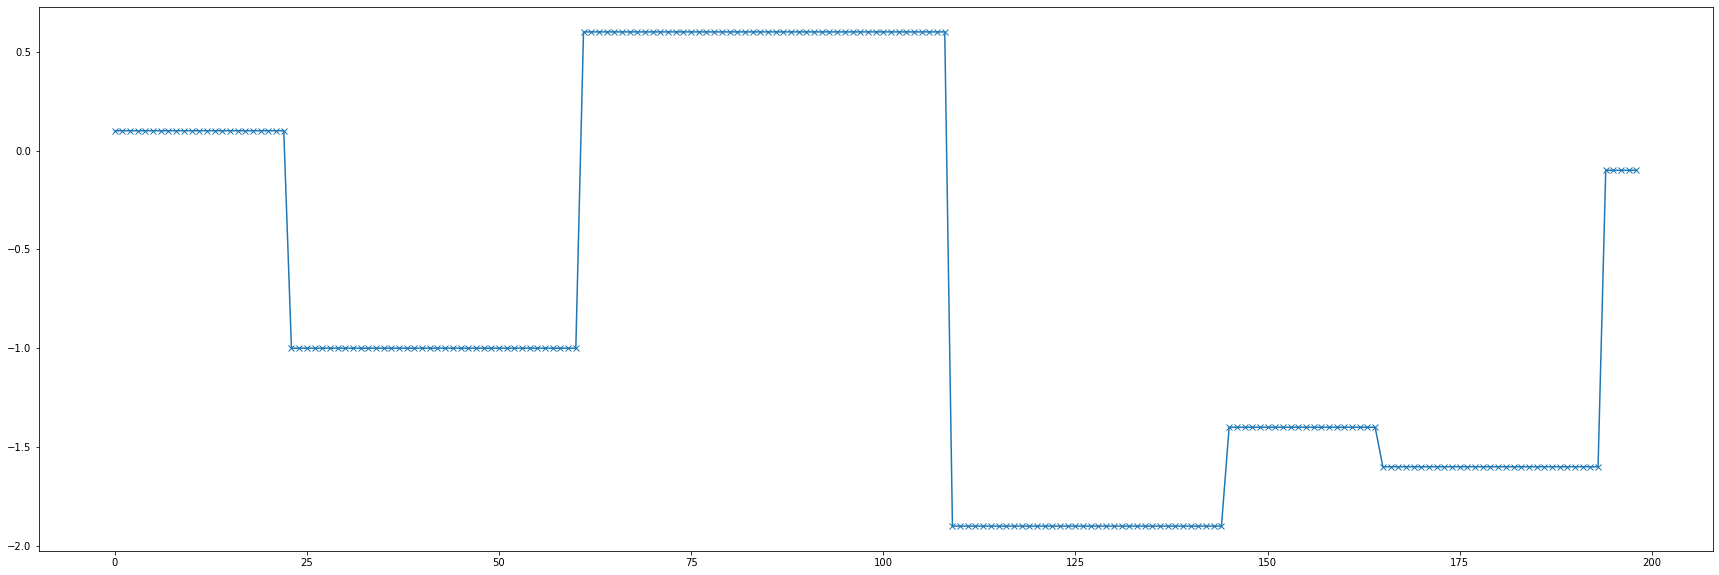

In [35]:
y_ref =[[np.random.randint(-20,20)/10]*l[0] for l in np.random.randint(20,50,(10,1))]
y_ref = np.hstack(y_ref).reshape(-1,1)[0:N-1,:]

fig,ax = plt.subplots(1,1)
fig.set_size_inches((30,10))
ax.plot(y_ref,marker='x')

Die Bewertung der Differenz zwischen Referenztrajektorie und prädizierter Trajektorie erfolgt mittels einer Kostenfunktion

In [33]:
L = cs.sumsqr((y_ref - y_est))

opti.minimize(L)

opti.solver('ipopt')

#opti.set_initial(S,X_init)
#opti.set_initial(U,U_init)

sol = opti.solve()

U_opt = sol.value(U)
X_opt = sol.value(S)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1594
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      597

Total number of variables............................:      599
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      400
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

Simulate model for optimized input trajectory

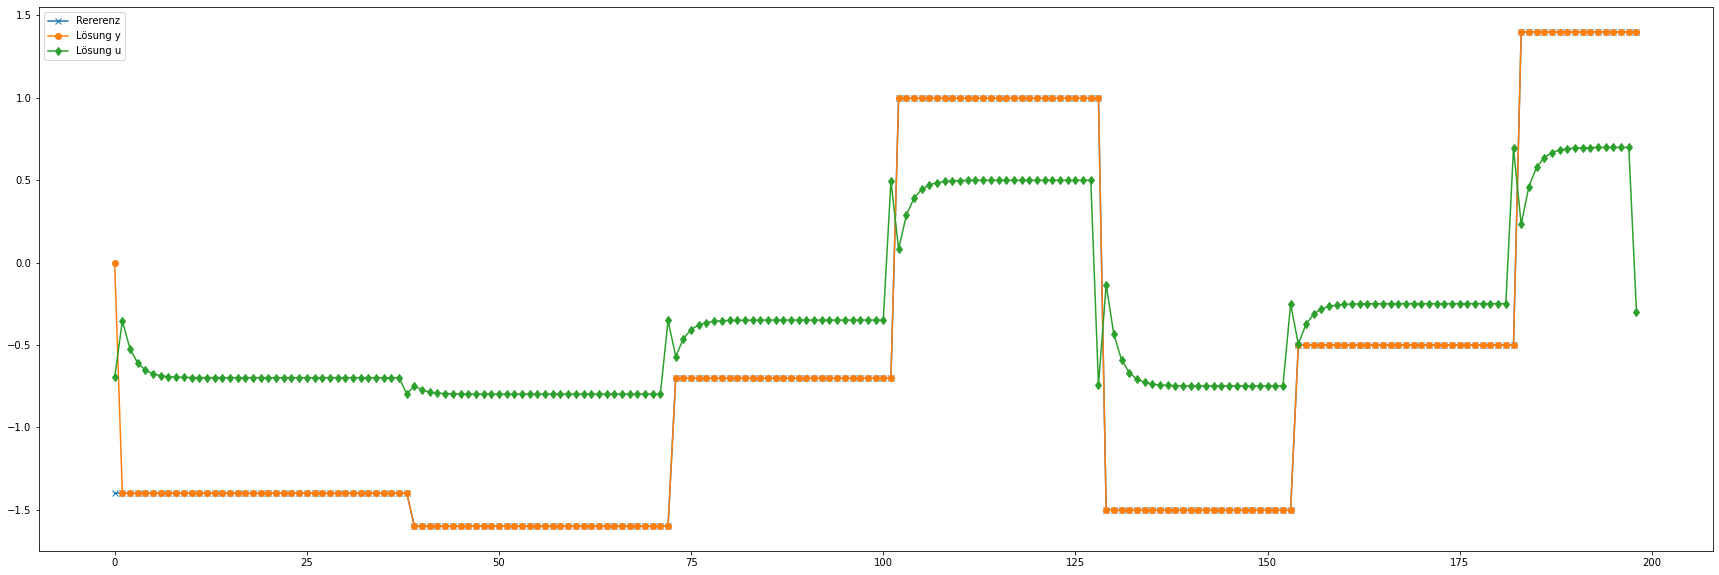

In [34]:
x_opt = [X_opt[:,0]]
y_opt = []

for k in range(U_opt.shape[0]):
    pred = f_model(u=U_opt[k],x=x_opt[-1],A=A_opt,B=B_opt,C=C_opt)
    
    x_opt.append(pred['x_new'])
    y_opt.append(pred['y'])

# opti.subject_to(S[0,:].T == np.array([[0],[0]]))    

# Listen in Arrays konvertieren
y_opt = cs.vcat(y_opt)
x_opt = cs.hcat(x_opt)



fig2,ax2 = plt.subplots(1,1)
fig2.set_size_inches((30,10))
#ax2.plot(x_opt.T,marker='d')
#ax2.plot(X_opt.T,marker='o')
#ax2.plot(U_opt.T,marker='x')
#ax2.plot(y_opt,marker='x')

ax2.plot(y_ref,marker='x')
ax2.plot(y_opt,marker='o')
ax2.plot(U_opt,marker='d')

ax2.legend(['Rererenz','Lösung y','Lösung u'])

Die Lösung des Optimalsteuerungsproblems basiert auf der Annahme, dass jede Stellgrößentrajektorie realisierbar ist. In praktischen Anwendungen existieren allerdings Beschränkungen bezüglich der realisierbaren Stellgrößen und Änderungen der Stellgrößen. Diese können durch Nebenbedingunen berücksichtigt werden: